In [1]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import read_quote      as rq
import stock_functions as sf
import df_visualizations as dv
import remap_values as rv

import sys
import time

In [2]:
%matplotlib inline
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (14, 10)

In [3]:
roll_nums = [3,5,7,10,12,15,18,20,22,25,28,30] # Generate an algorithm for predicting every few days
mom_nums  = [3,5,10,15,20,25,30]               # Momentum has many good tracers
rsi_nums  = [5,10,15,20,25]                    # Good for some long term trends
band_nums = [5,10,15,20,25]                    # A few trace different areas well

In [4]:
longFileList = ['aapl','acm','amzn','awk','awr','bac','ba','cat','c','cop','cvx','dal','dd','farm','fdp',
               'gnc','hes','ibm','mas','mcd','mon','msex','msft','nflx','sbux','strl','tgt','tsla','ups','vmc','xom','xpo']

inpFileList = ['aapl','awr','ba','cat','cop','dal','farm','gnc','hes','mas','mon','nflx','sbux','tsla','ups']

In [42]:
def gen_data( inpList, roll_n, mom_n, rsi_n, band_n ):

    quote_df_list = []
    
    for i in range( 0, len(inpList)):
            fileName = 'quotes/'+inpList[i]+'.csv'
            quote = rq.readQuote( fileName )

            # Generate features
            diffs = sf.generate_differentials   ( quote            ).drop('diff_v',axis=1)
            moms  = sf.generate_momentum_close  ( quote, mom_nums  )
            rsis  = sf.generate_rsi             ( quote, rsi_nums  )
            bands = sf.generate_bollinger_bands ( quote, band_nums )
            rolls = sf.generate_rolling_close   ( quote, roll_nums, onlyMean=True )
            dates = sf.get_frac_year_vars       ( quote            )
    
            # Seasonality in some stocks
            categ = sf.get_seasonal_stocks      ( inpList[i], quote.shape[0] )
            categ.index = quote.index
    
            # Log of current price minus 1.5, gives proxy for price percentage movement
            l_cp_m = np.log10( quote['close'] )

            
            # The target variables are stored in the data frame
            # Fractional component increased/decreased next day
#            for i in roll_nums:
#                rolls['close_mean_'+str(i)] = ( rolls['close_mean_'+str(i)].shift(i) / rolls['close_mean_'+str(i)] - 1 )
#            rolls = rolls.replace( [np.inf, -np.inf], np.nan )


            # The predicted value column heads
#            target_list = rolls.columns.values

            
            # Combine all the data frames
            var_df_list = [ diffs, moms, rsis, bands, dates, categ, l_cp_m ]#, rolls ]
            all_variables = reduce( lambda left,right: left.join(right,how='inner'), var_df_list )
            
            quote_df_list.append( all_variables )
            
    
            
    return pd.concat( quote_df_list )

In [43]:
my_df = gen_data( longFileList, roll_nums, mom_nums, rsi_nums, band_nums )

In [44]:
my_df.shape

(77750, 27)

In [104]:
my_df.columns.values

array(['diff_co', 'diff_hl', 'momentum_3', 'momentum_5', 'momentum_10',
       'momentum_15', 'momentum_20', 'momentum_25', 'momentum_30', 'rsi_5',
       'rsi_10', 'rsi_15', 'rsi_20', 'rsi_25', 'bollinger_5',
       'bollinger_10', 'bollinger_15', 'bollinger_20', 'bollinger_25',
       'frac_year_1', 'frac_year_2', 'agri_ind', 'cons_ind', 'ener_ind',
       'tran_ind', 'wate_ind', 'close', 'log_diff_hl'], dtype=object)

In [115]:
scale_dict = {}

diffs, co can z scale, hl can smartscale sigma2

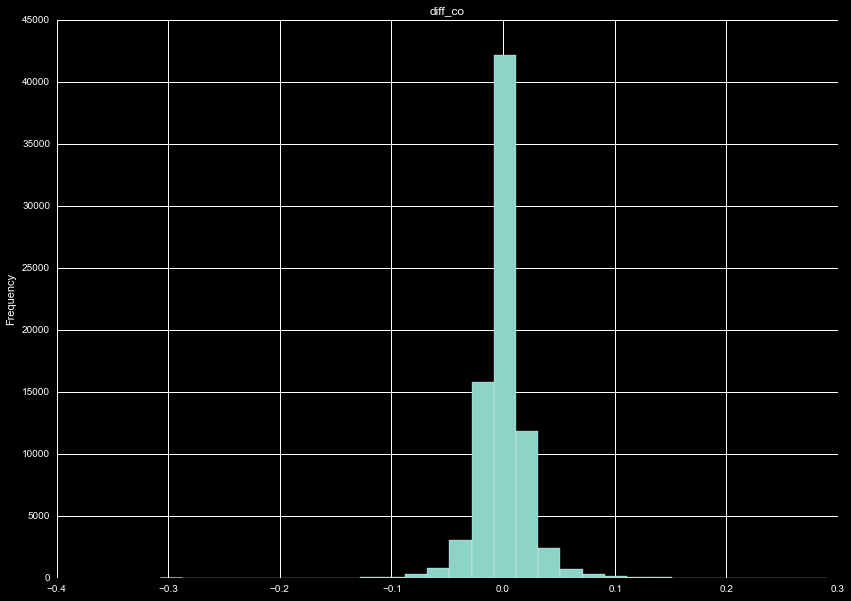

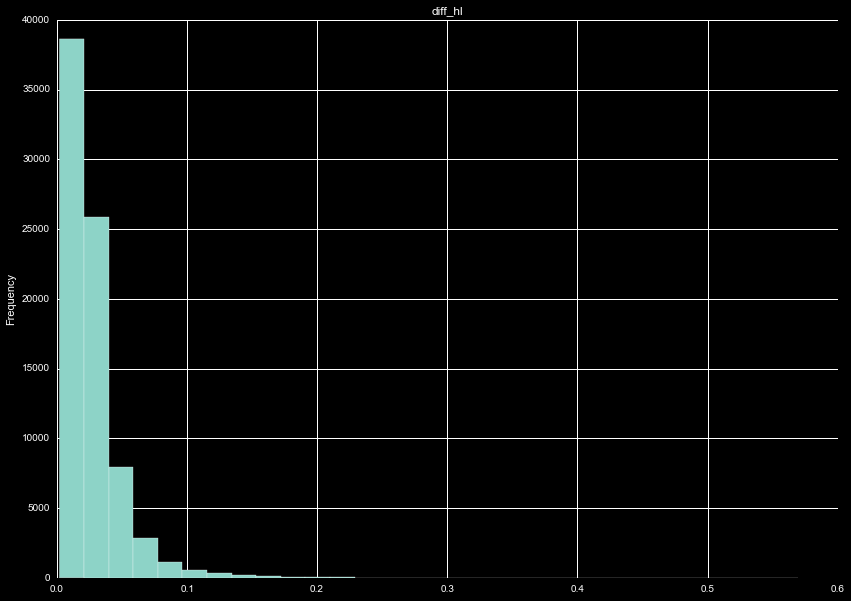

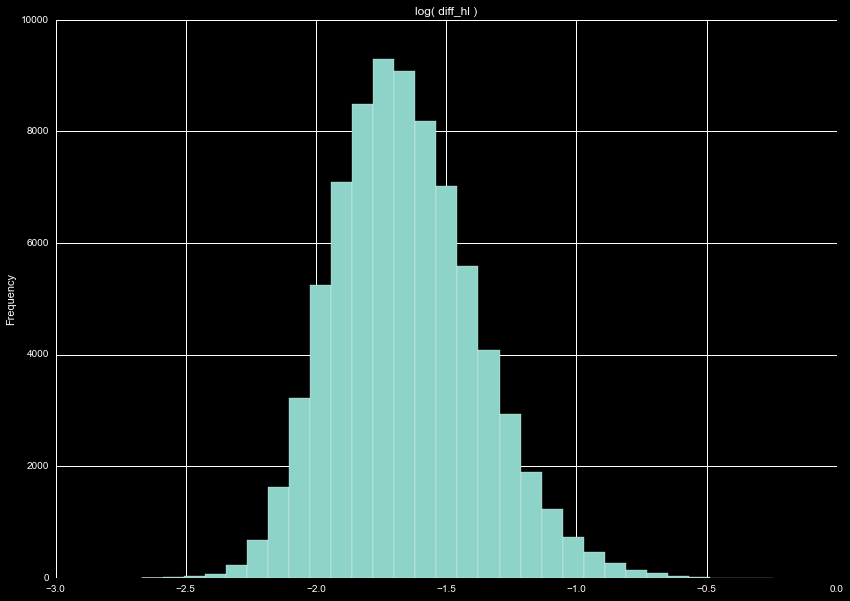

In [45]:
for label in ['diff_co','diff_hl']:
    my_df[label].plot.hist( bins=30, title=label )
    plt.show()

np.log10( my_df['diff_hl'] ).plot.hist( bins=30, title='log( diff_hl )' )
plt.show()

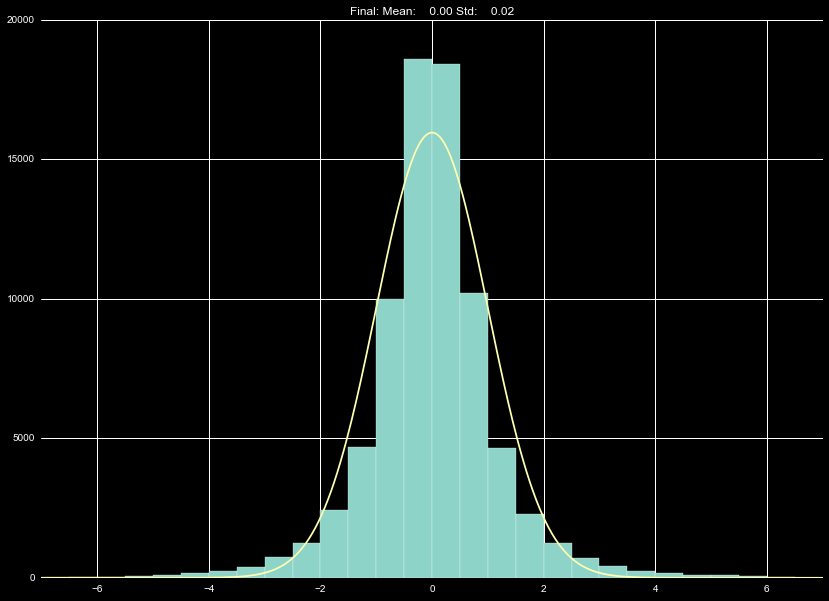

count    77750.000000
mean         0.006622
std          1.266272
min        -18.513710
25%         -0.532473
50%         -0.000714
75%          0.534312
max         17.501727
Name: diff_co, dtype: float64


In [67]:
foo, vals = rv.smart_scale( my_df, 'diff_co', n_sigma=8.0, show_final=True, curve_boost=4e4, return_coeff=True )
print foo.describe()

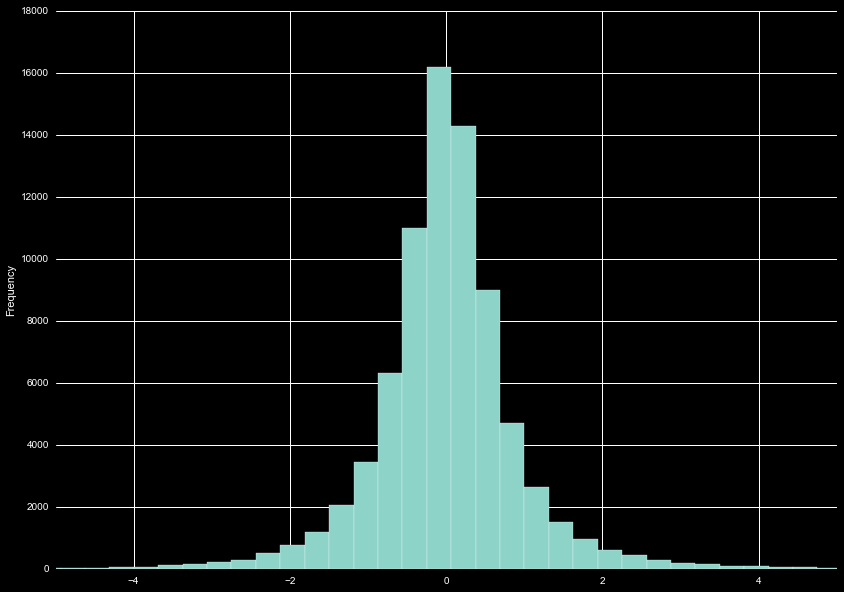

In [106]:
foo = rv.scale_column( my_df, 'diff_co' )
foo.plot.hist( bins=91 )
plt.xlim(-5,5)
plt.show()

In [116]:
scale_dict['diff_co_mean'] = my_df['diff_co'].mean()
scale_dict['diff_co_std' ] = my_df['diff_co'].std()

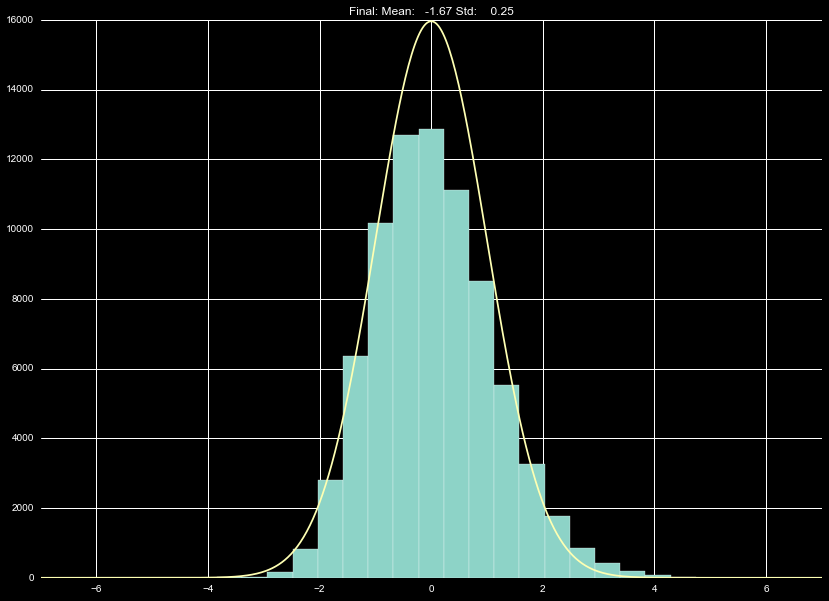

count    77750.000000
mean         0.049195
std          1.076779
min         -3.950637
25%         -0.715174
50%         -0.029215
75%          0.733585
max          5.608625
Name: log_diff_hl, dtype: float64


In [117]:
my_df['log_diff_hl'] = np.log10( my_df['diff_hl'] )
foo, vals = rv.smart_scale( my_df, 'log_diff_hl', n_sigma=2.0, show_final=True, curve_boost=4e4, return_coeff=True )
scale_dict['log_diff_hl_mean'] = vals[0]
scale_dict['log_diff_hl_std' ] = vals[1]
print foo.describe()

Momentum, z scaling does well

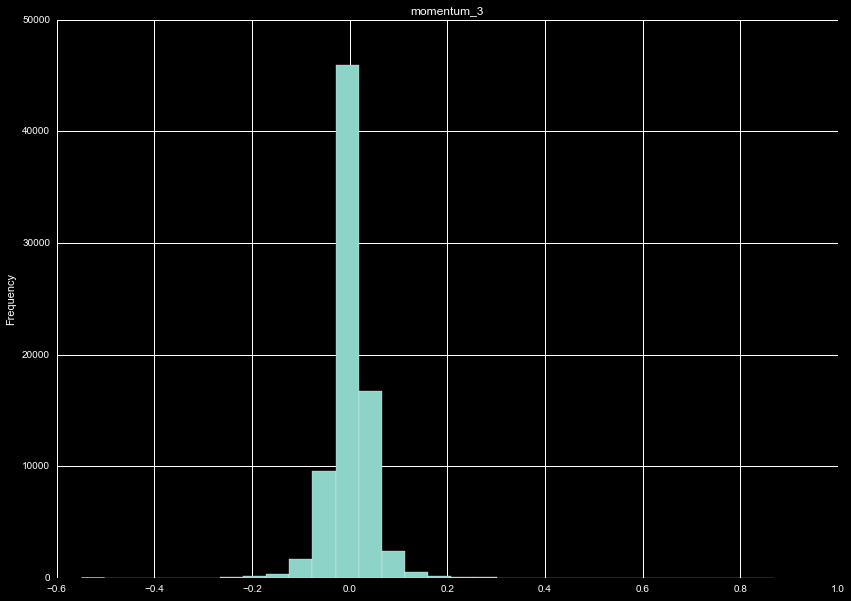

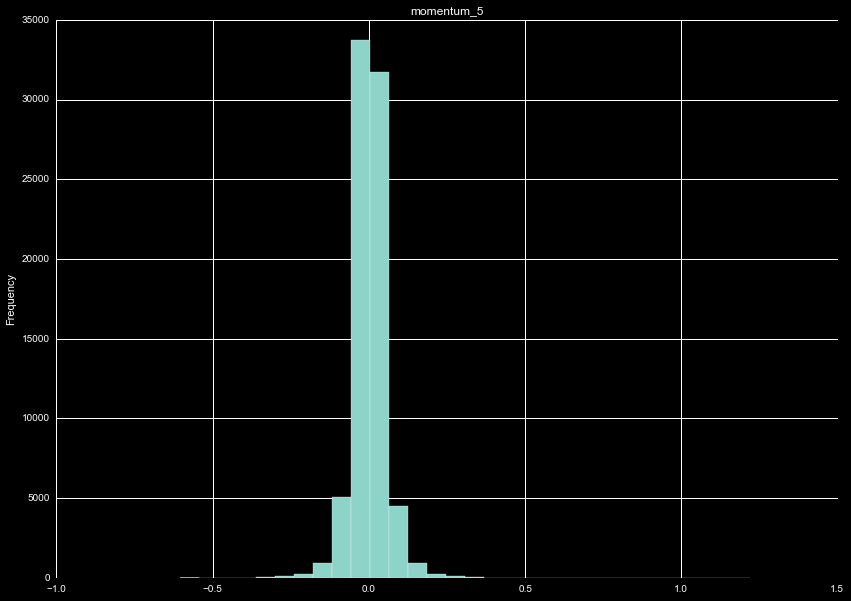

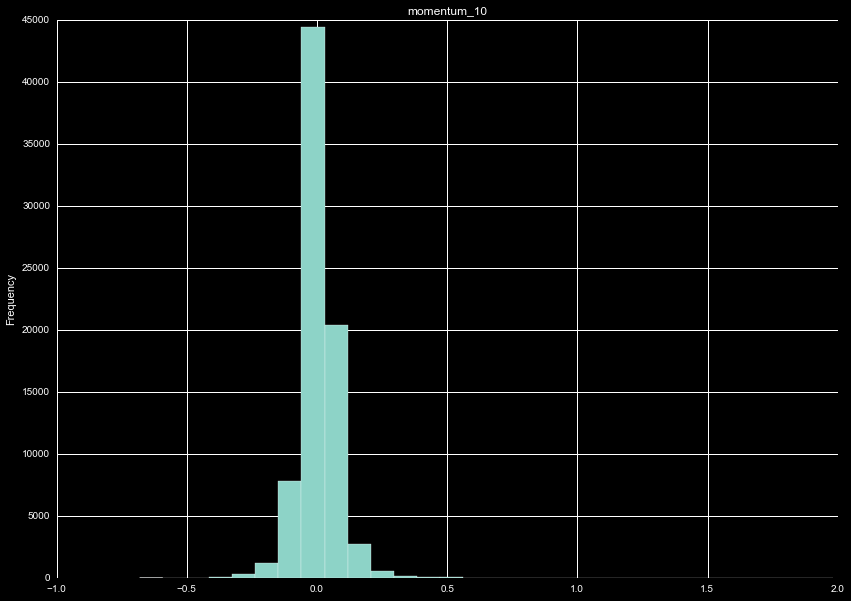

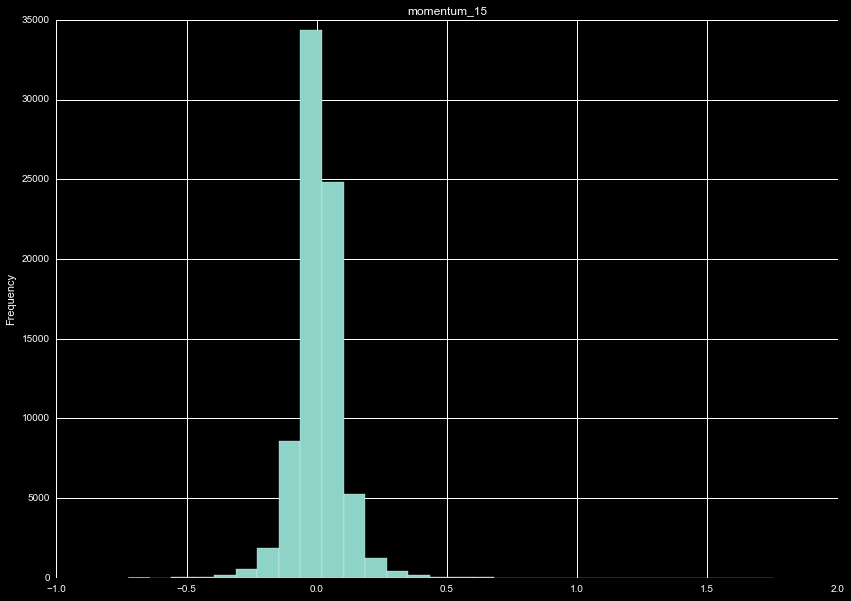

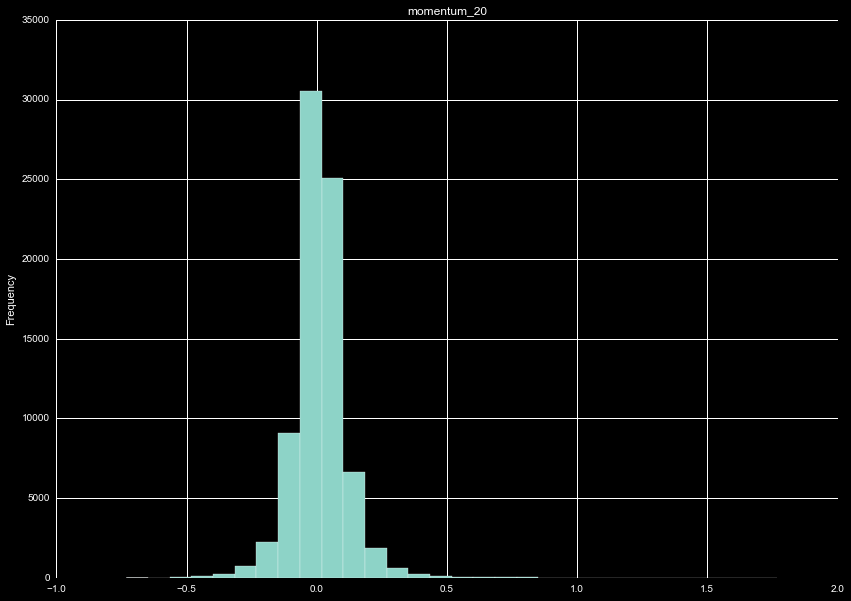

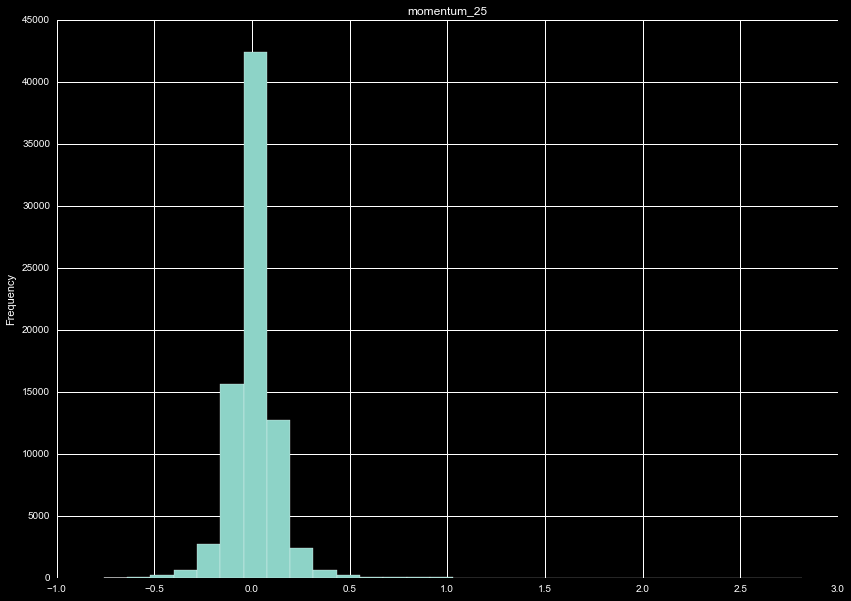

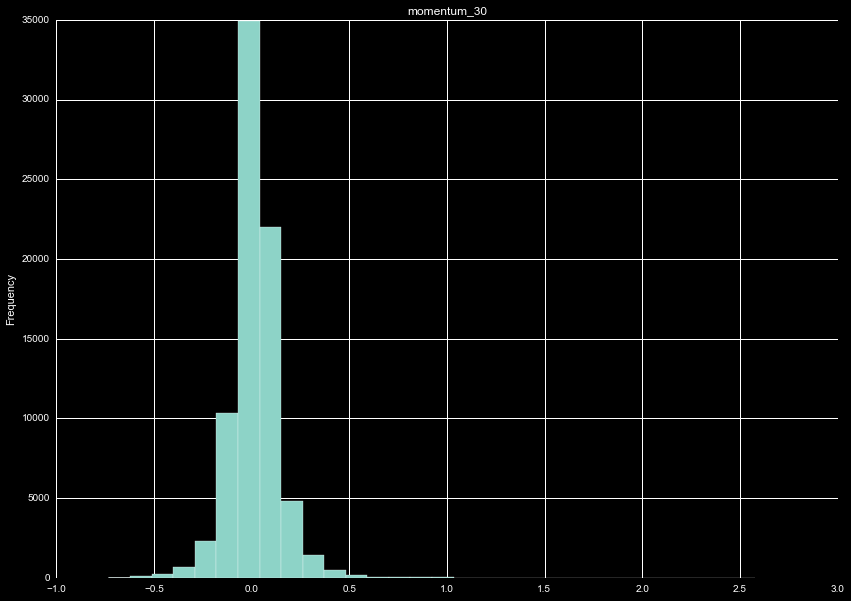

In [71]:
for i in mom_nums:
    label = 'momentum_'+str(i)
    my_df[label].plot.hist( bins=30, title=label )
    plt.show()

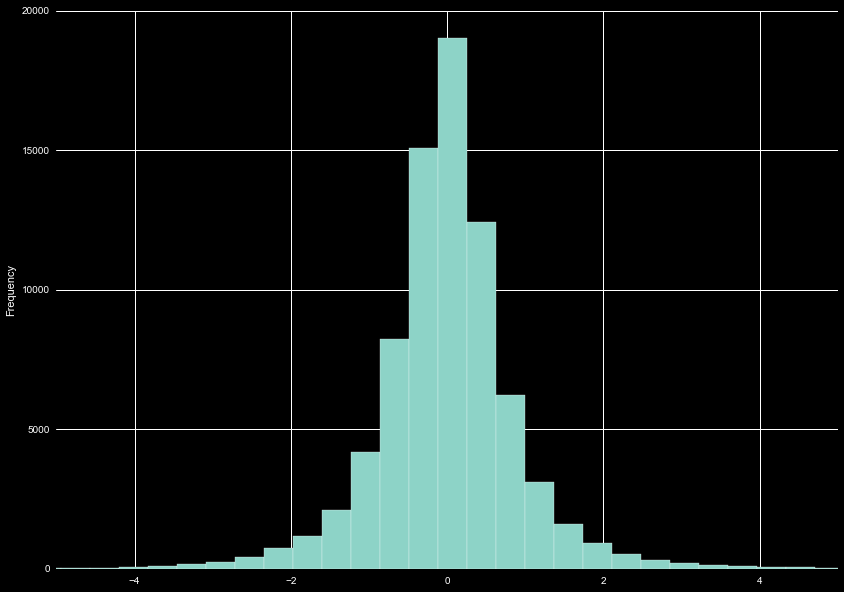

count    7.775000e+04
mean    -1.183078e-15
std      1.000000e+00
min     -1.312165e+01
25%     -4.346189e-01
50%     -4.896237e-03
75%      4.191599e-01
max      2.068826e+01
Name: momentum_3, dtype: float64


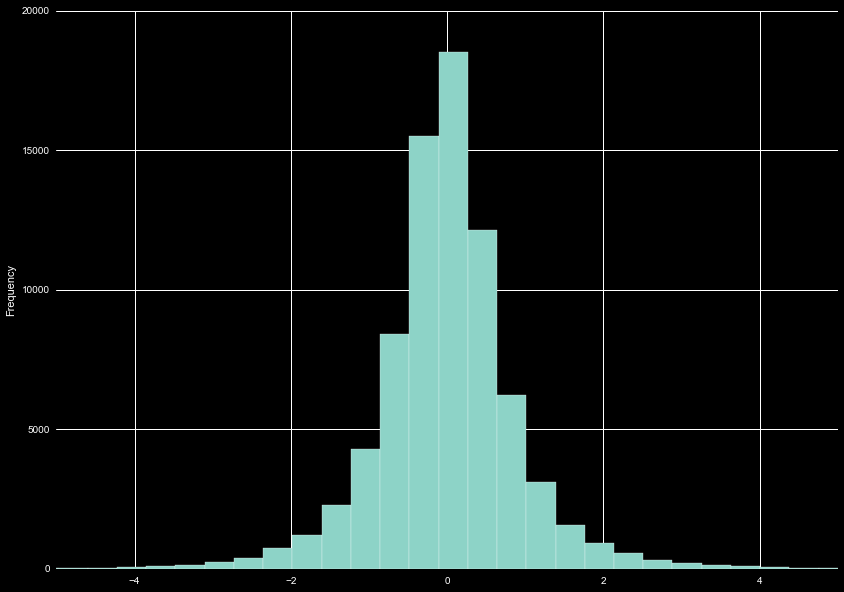

count    7.775000e+04
mean     5.850591e-15
std      1.000000e+00
min     -1.133626e+01
25%     -4.405575e-01
50%     -8.447037e-03
75%      4.281879e-01
max      2.272195e+01
Name: momentum_5, dtype: float64


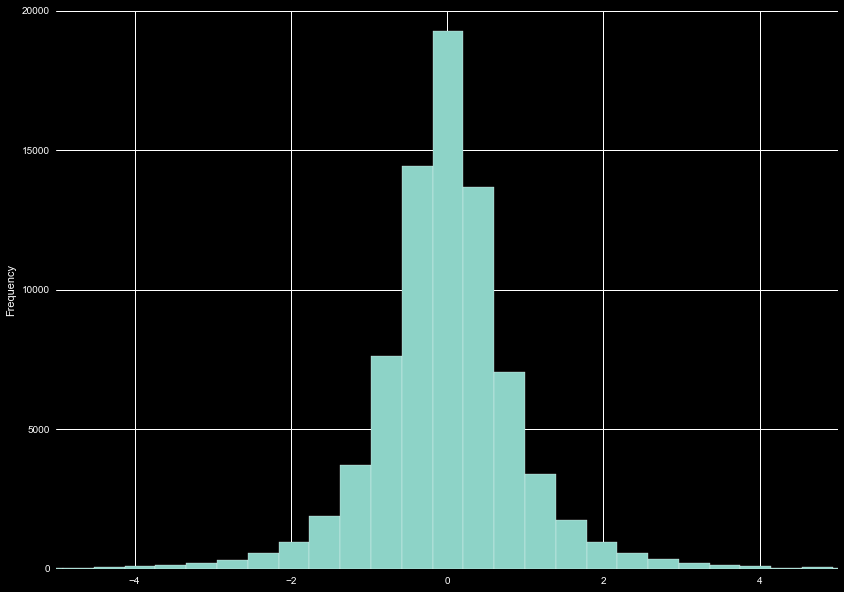

count    7.775000e+04
mean     1.951245e-13
std      1.000000e+00
min     -9.252468e+00
25%     -4.557678e-01
50%     -1.195130e-02
75%      4.385752e-01
max      2.662021e+01
Name: momentum_10, dtype: float64


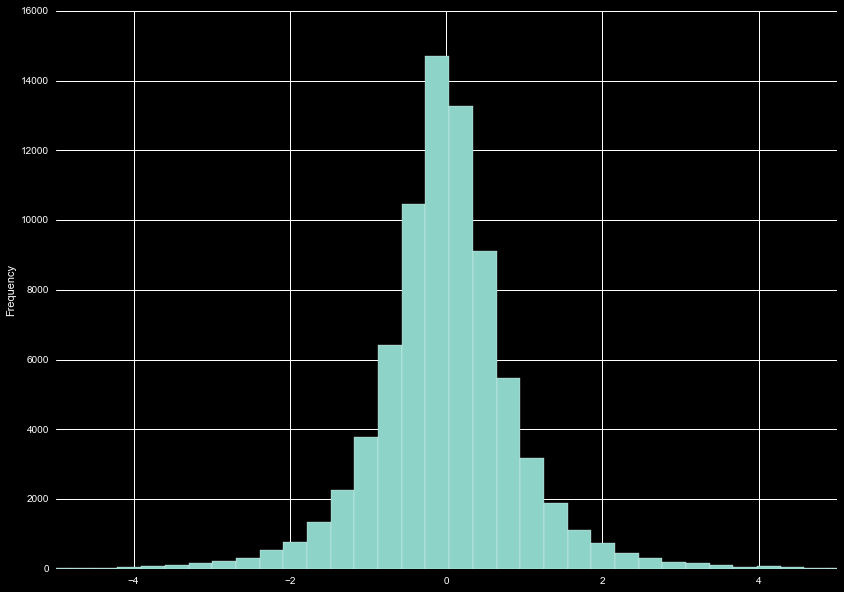

count    7.775000e+04
mean    -1.125361e-13
std      1.000000e+00
min     -8.150289e+00
25%     -4.652346e-01
50%     -1.569869e-02
75%      4.456121e-01
max      1.944585e+01
Name: momentum_15, dtype: float64


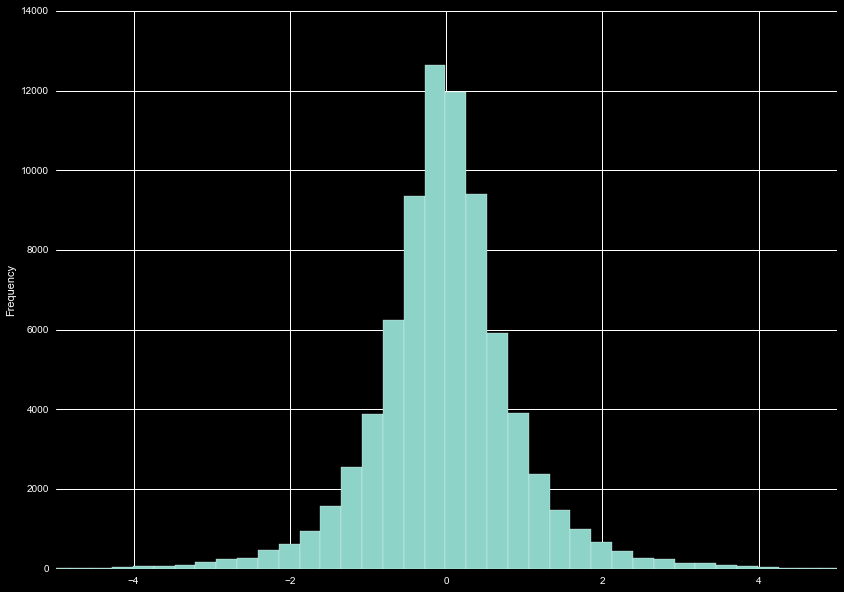

count    7.775000e+04
mean     9.397104e-14
std      1.000000e+00
min     -7.209932e+00
25%     -4.762708e-01
50%     -2.020272e-02
75%      4.446218e-01
max      1.705581e+01
Name: momentum_20, dtype: float64


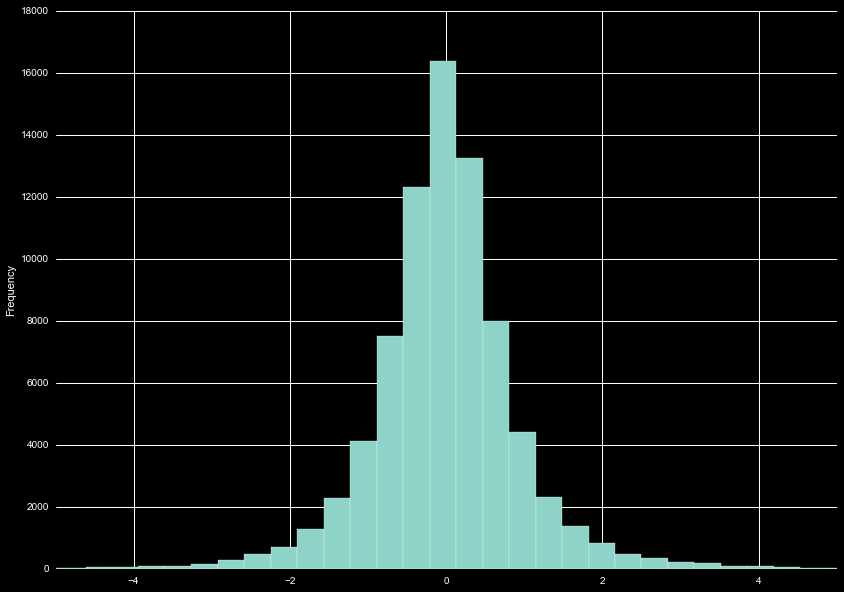

count    7.775000e+04
mean     1.588087e-13
std      1.000000e+00
min     -6.650560e+00
25%     -4.749633e-01
50%     -2.629342e-02
75%      4.406473e-01
max      2.418863e+01
Name: momentum_25, dtype: float64


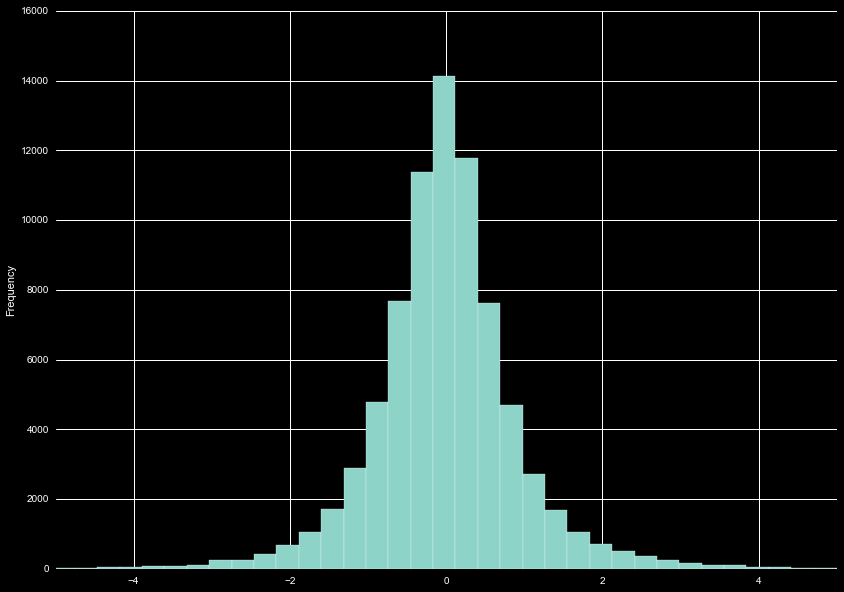

count    7.775000e+04
mean     9.455241e-14
std      1.000000e+00
min     -5.898262e+00
25%     -4.764912e-01
50%     -2.970466e-02
75%      4.336943e-01
max      2.017402e+01
Name: momentum_30, dtype: float64


In [108]:
for i in mom_nums:
    label = 'momentum_'+str(i)
    foo = rv.scale_column(my_df,label)#smart_scale( my_df, label, n_sigma=10.0, show_final=True, curve_boost=1e4, return_coeff=True, )
    #vals[0] = foo.mean()
    #vals[1] = foo.std()
    #scale_dict[label+'_mean'] = my_df[label].mean()
    #scale_dict[label+'_std' ] = my_df[label].std()
    foo.plot.hist( bins=91 )
    plt.xlim(-5,5)
    plt.show()
    print foo.describe()

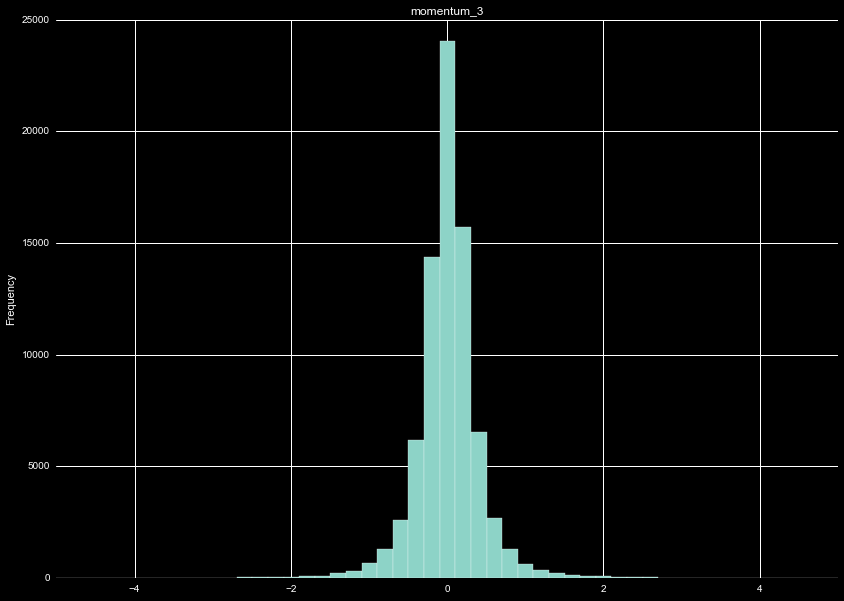

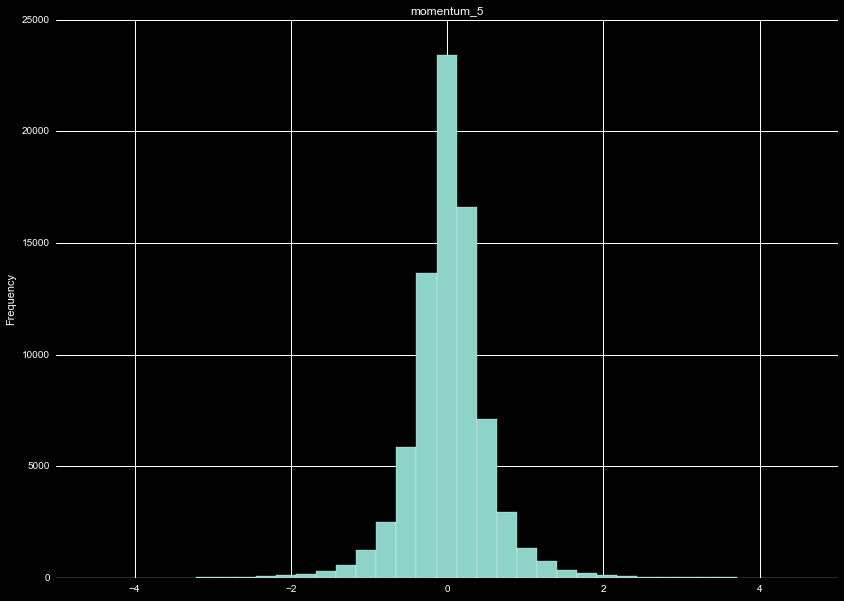

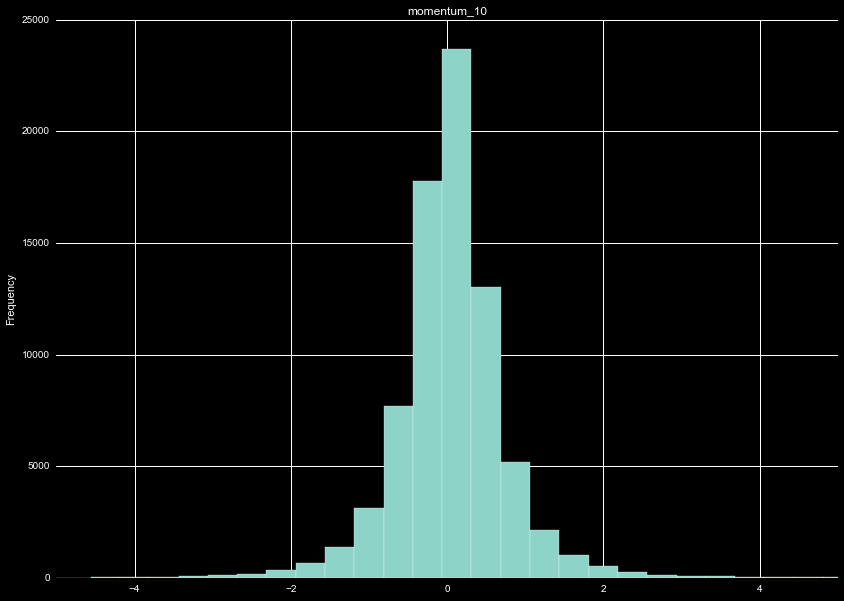

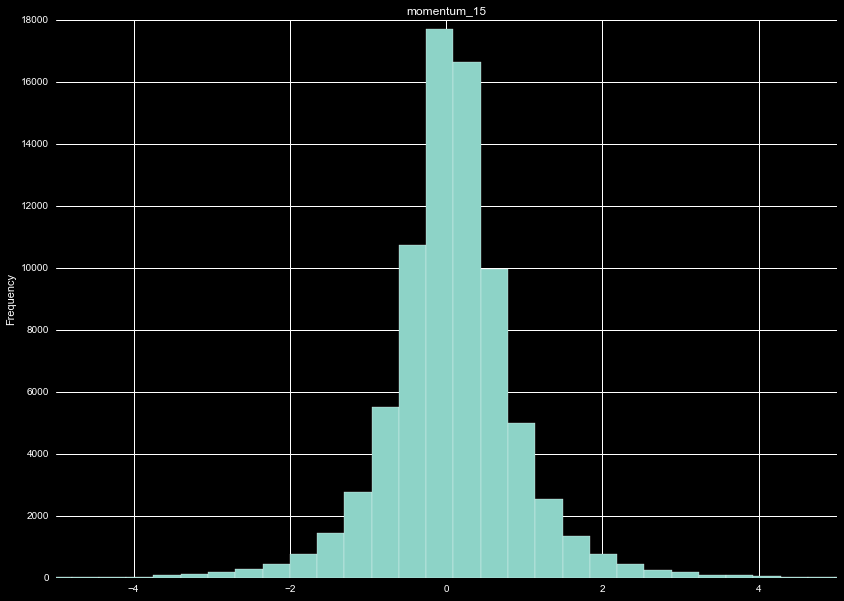

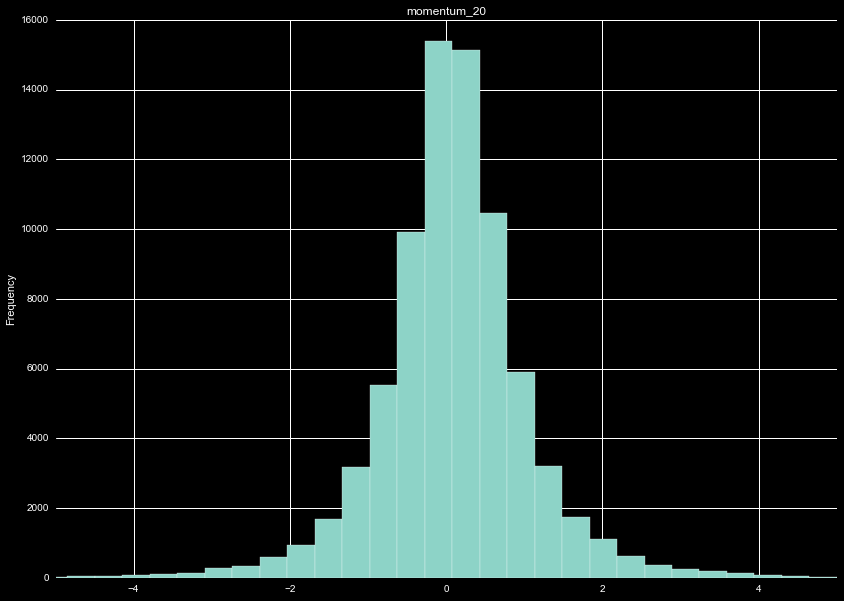

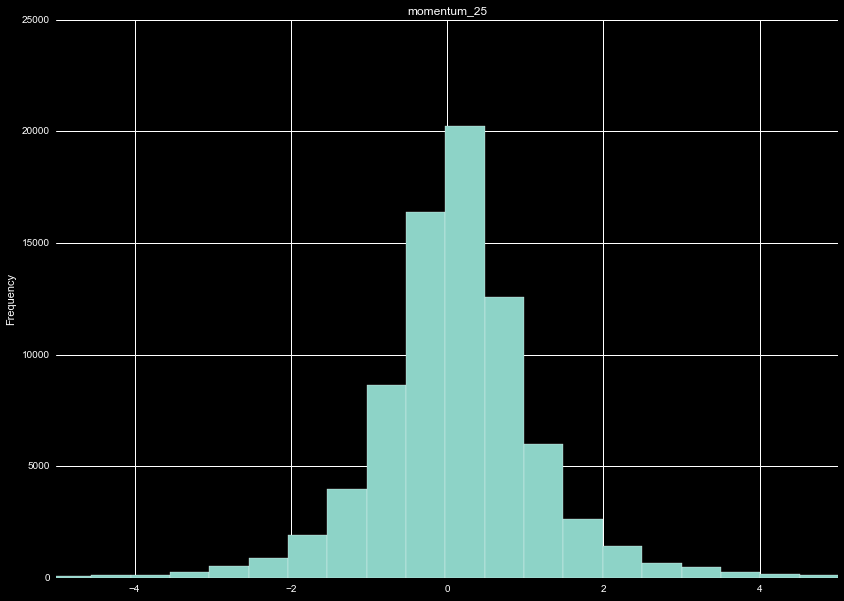

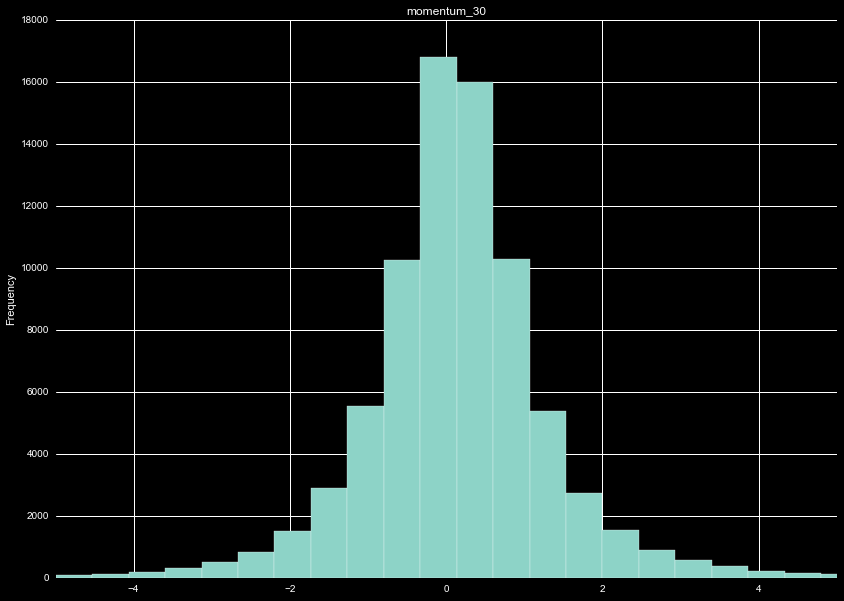

In [114]:
for i in mom_nums:
    label = 'momentum_'+str(i)
    ( (my_df[label]-0.0) / 0.1 ).plot.hist( bins=71, title=label )
    plt.xlim(-5,5)
    plt.show()

In [119]:
scale_dict['momentum_mean'] = 0.0
scale_dict['momentum_std' ] = 0.1

RSI, do a modified zscaling. Center of distribution is clearly 0.5 by definition, using std of 0.2 for all will put in same window, and sort of resemble a normal distribution

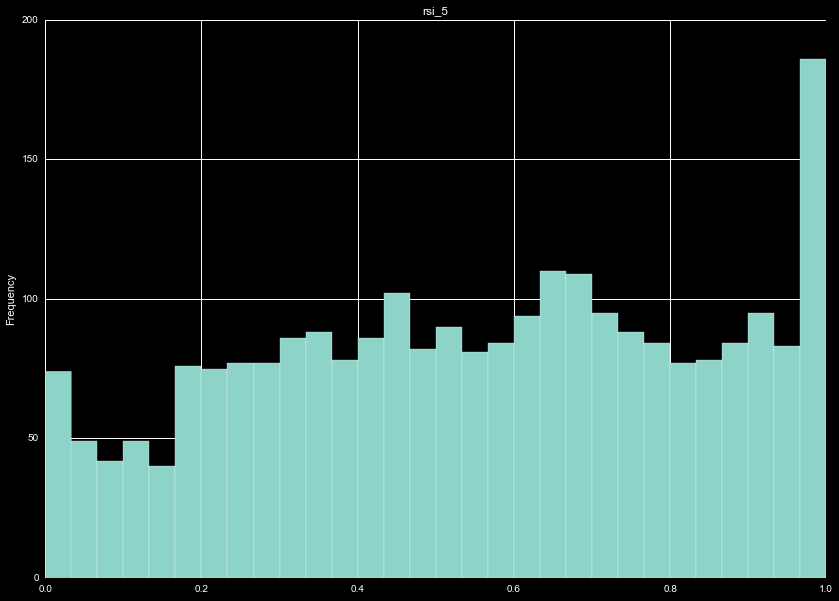

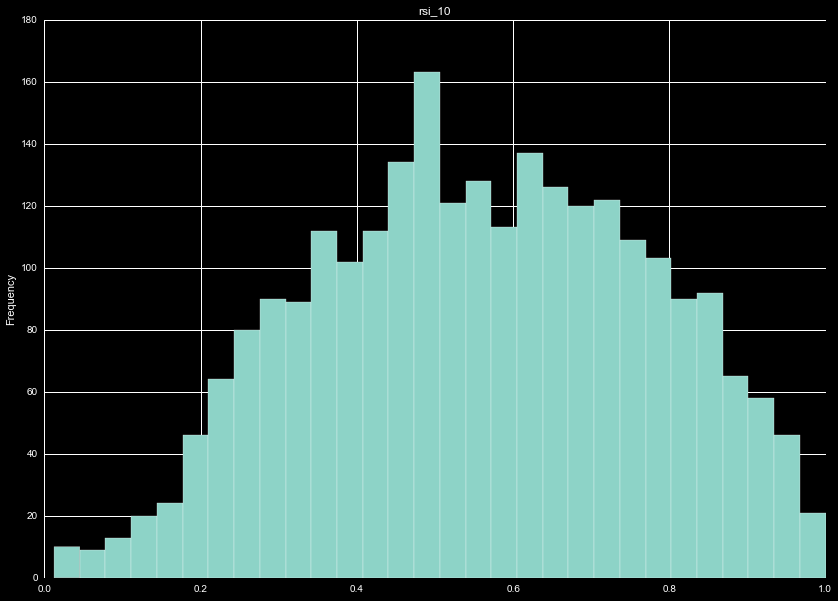

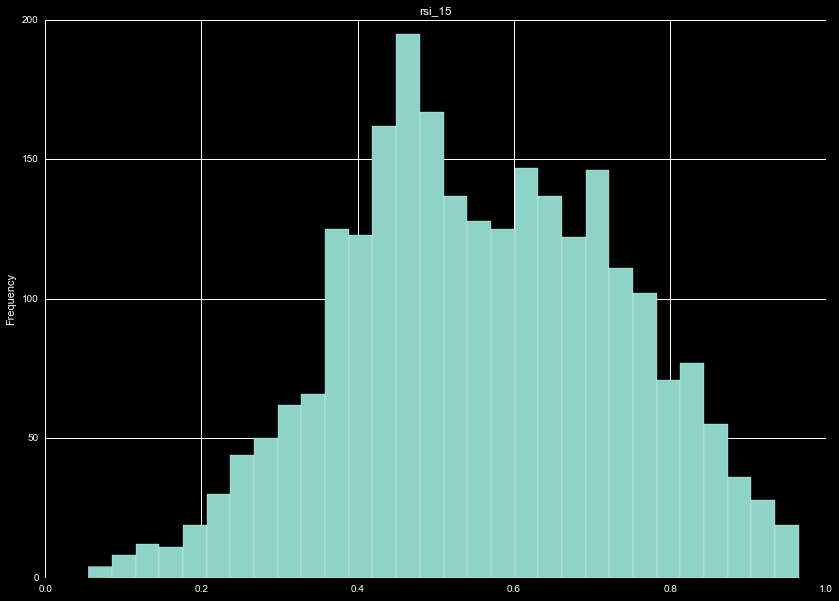

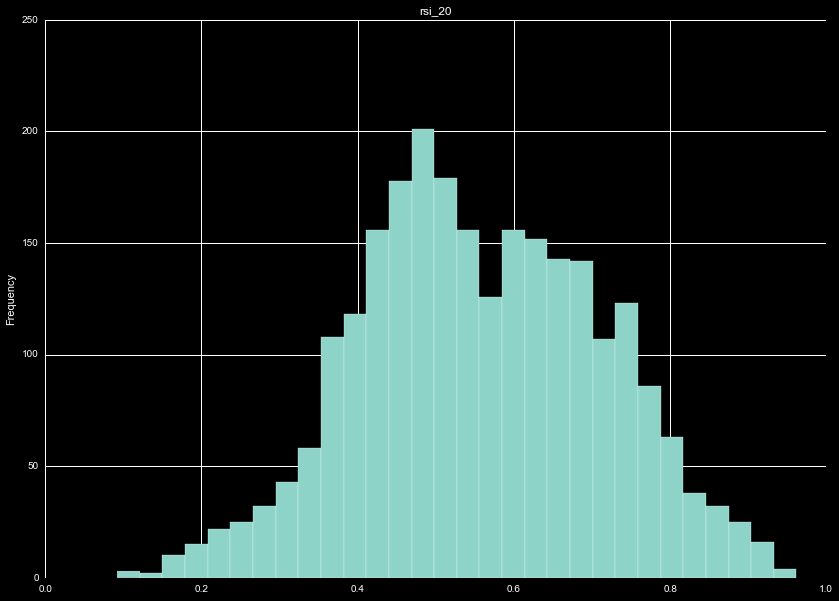

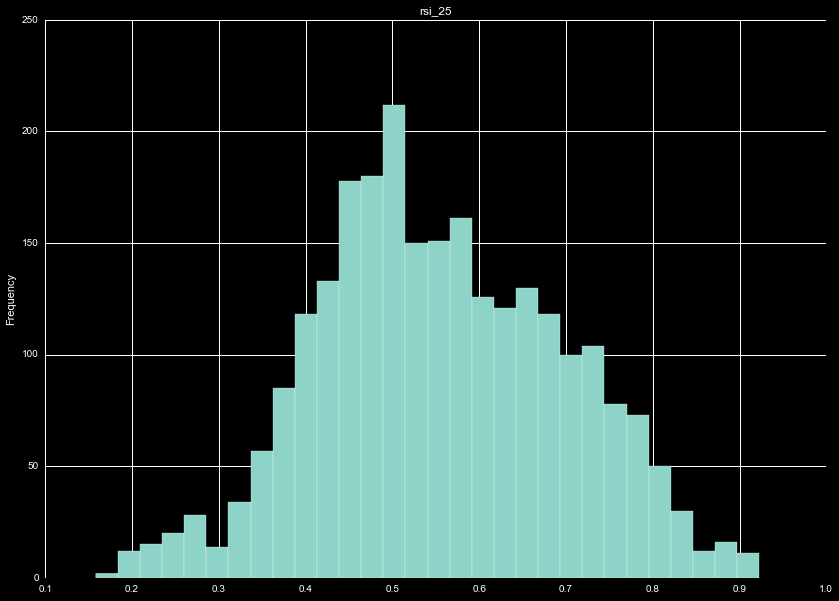

In [27]:
for i in rsi_nums:
    label = 'rsi_'+str(i)
    my_df[label].plot.hist( bins=30, title=label )
    plt.show()

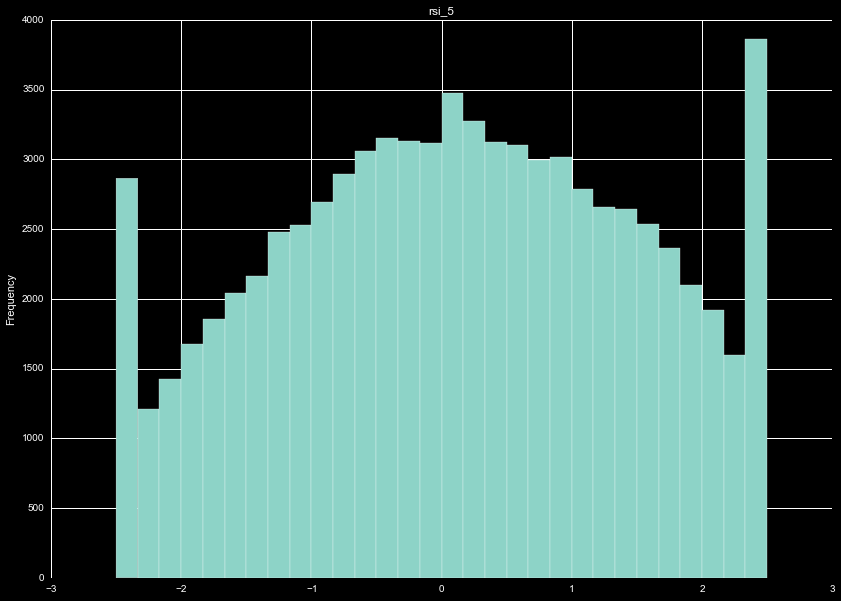

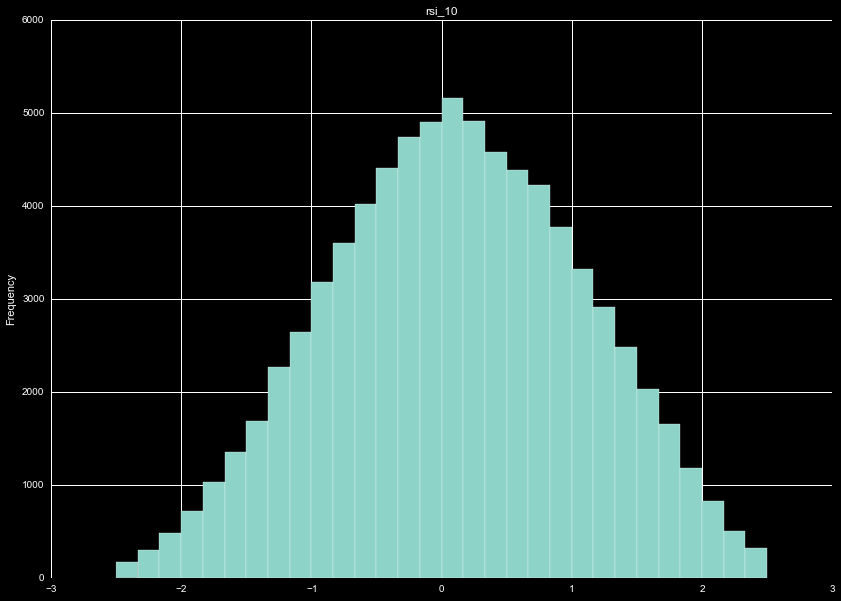

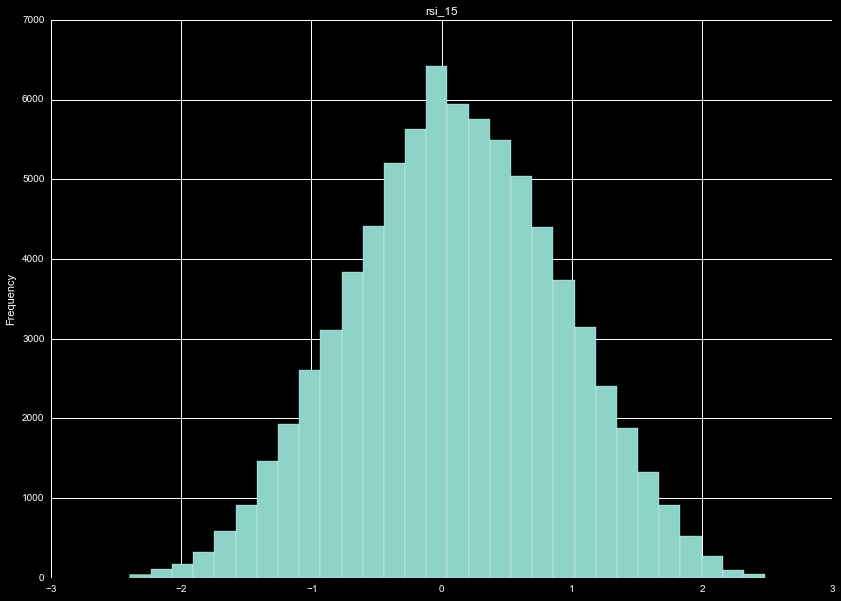

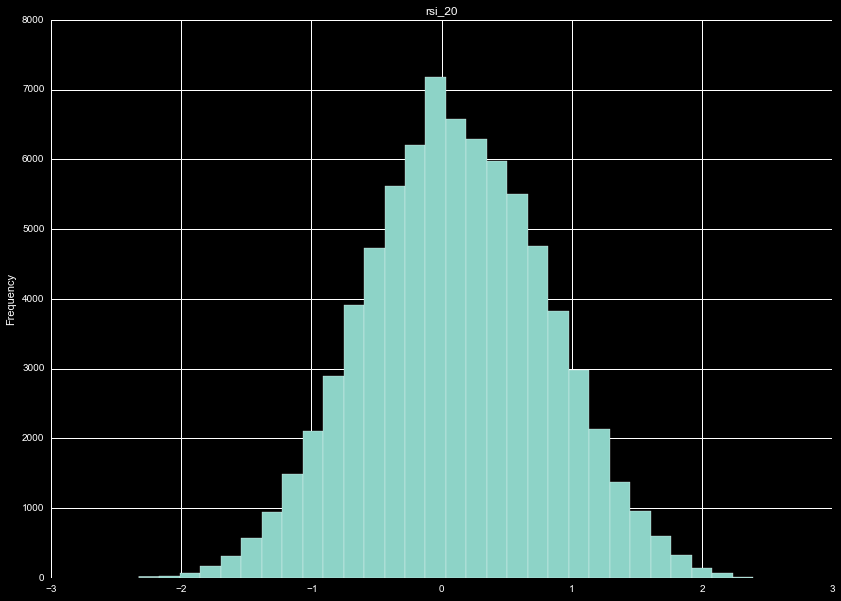

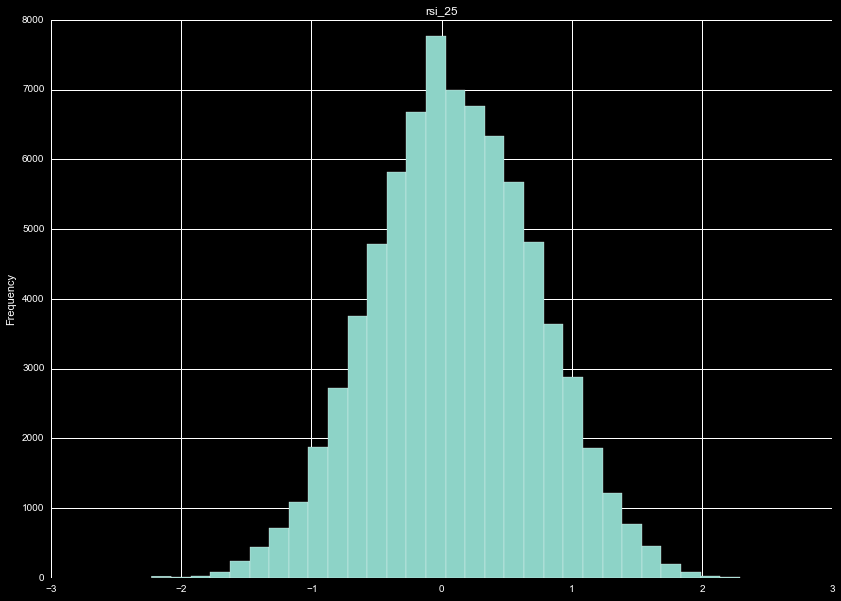

In [95]:
for i in rsi_nums:
    label = 'rsi_'+str(i)
    ( (my_df[label] - 0.5) / 0.2 ).plot.hist( bins=30, title=label )
    plt.show()

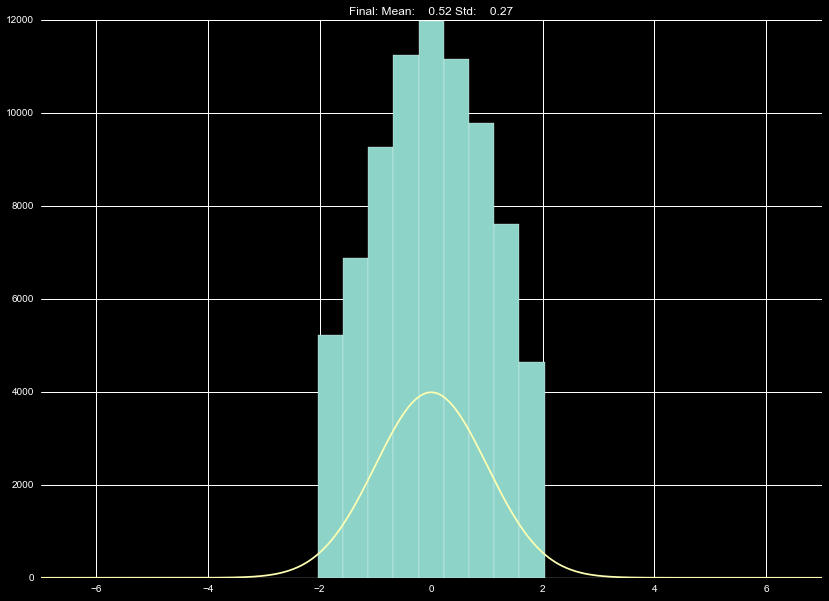

count    7.775000e+04
mean     5.563020e-15
std      1.000000e+00
min     -1.925025e+00
25%     -7.634553e-01
50%      7.845657e-03
75%      7.917516e-01
max      1.765001e+00
Name: rsi_5, dtype: float64


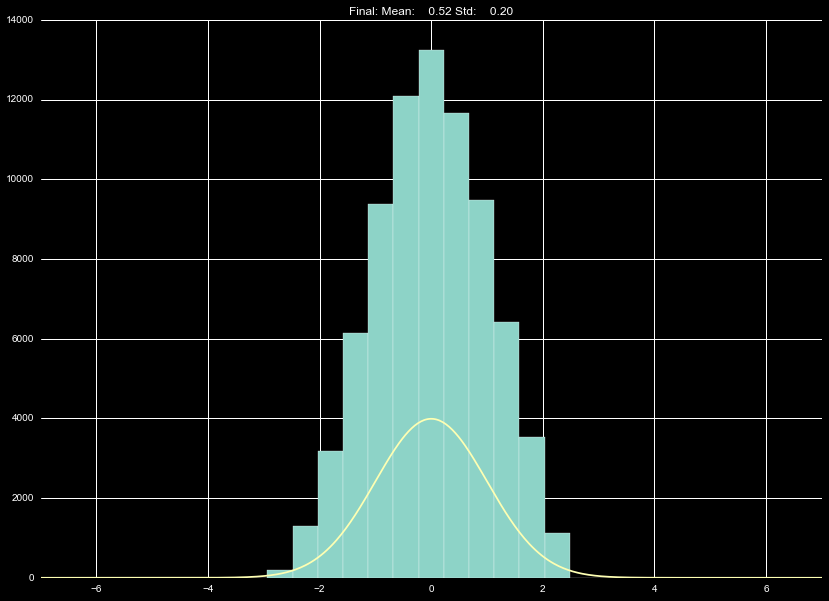

count    7.775000e+04
mean    -3.006047e-14
std      1.000000e+00
min     -2.676638e+00
25%     -7.097307e-01
50%     -5.477851e-03
75%      7.211010e-01
max      2.450307e+00
Name: rsi_10, dtype: float64


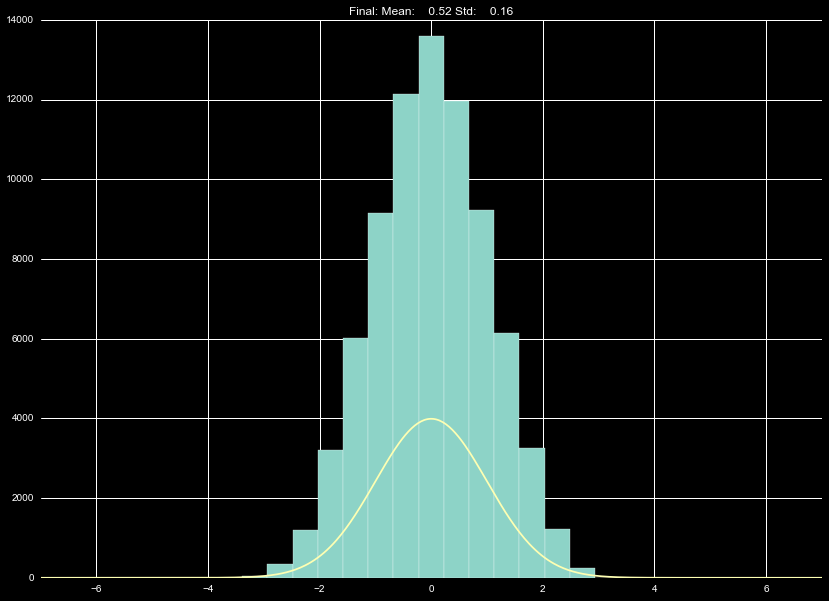

count    77750.000000
mean        -0.003222
std          1.009457
min         -3.146538
25%         -0.698349
50%         -0.010793
75%          0.705448
max          2.980960
Name: rsi_15, dtype: float64


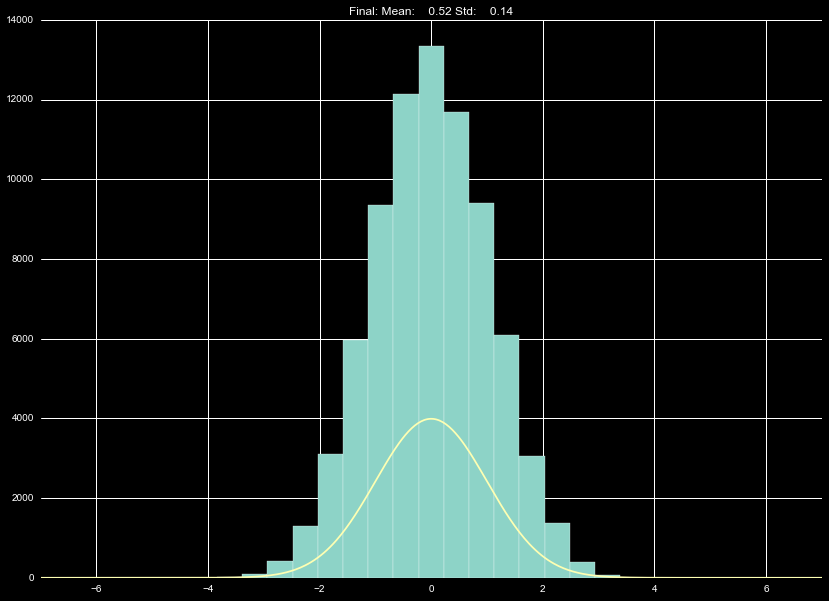

count    77750.000000
mean        -0.002164
std          1.028975
min         -3.590610
25%         -0.709848
50%         -0.017112
75%          0.716138
max          3.370510
Name: rsi_20, dtype: float64


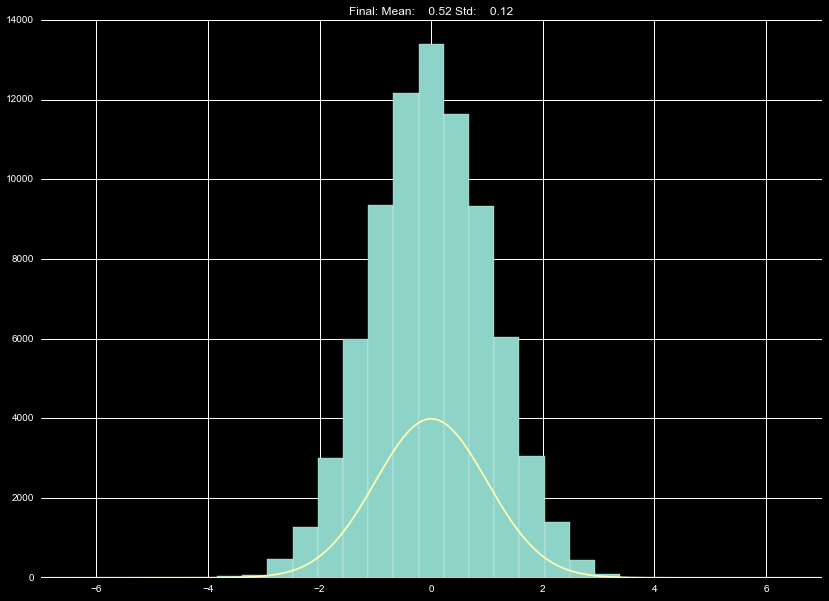

count    77750.000000
mean        -0.002372
std          1.034293
min         -3.862763
25%         -0.710092
50%         -0.026529
75%          0.714663
max          3.613223
Name: rsi_25, dtype: float64


In [93]:
for i in rsi_nums:
    label = 'rsi_'+str(i)
    foo, vals = rv.smart_scale( my_df, label, n_sigma=2.0, show_final=True, curve_boost=1e4, return_coeff=True )
    #scale_dict[label+'_mean'] = vals[0]
    #scale_dict[label+'_std' ] = vals[1]
    print foo.describe()

In [120]:
scale_dict['rsi_mean'] = 0.5
scale_dict['rsi_std' ] = 0.2

Bollinger bands, already centered at 0, use std of 0.65 for proper spread

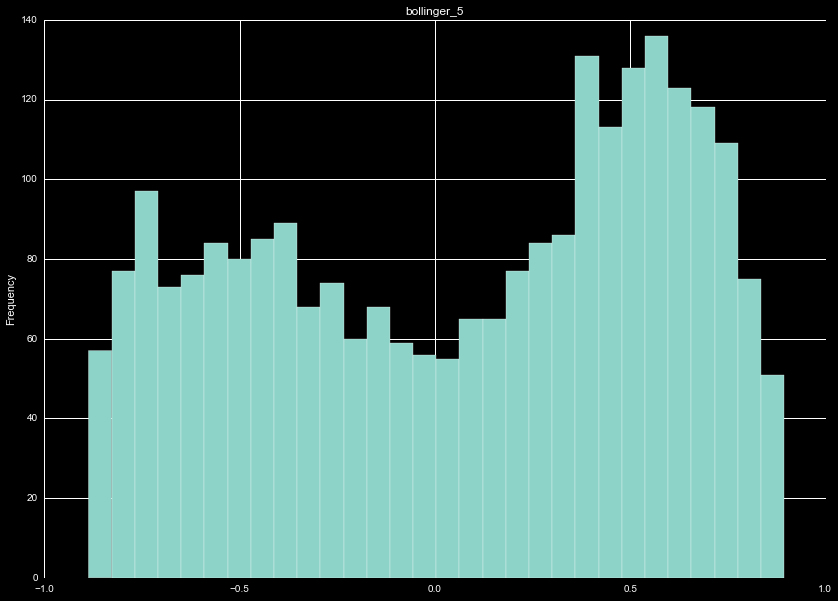

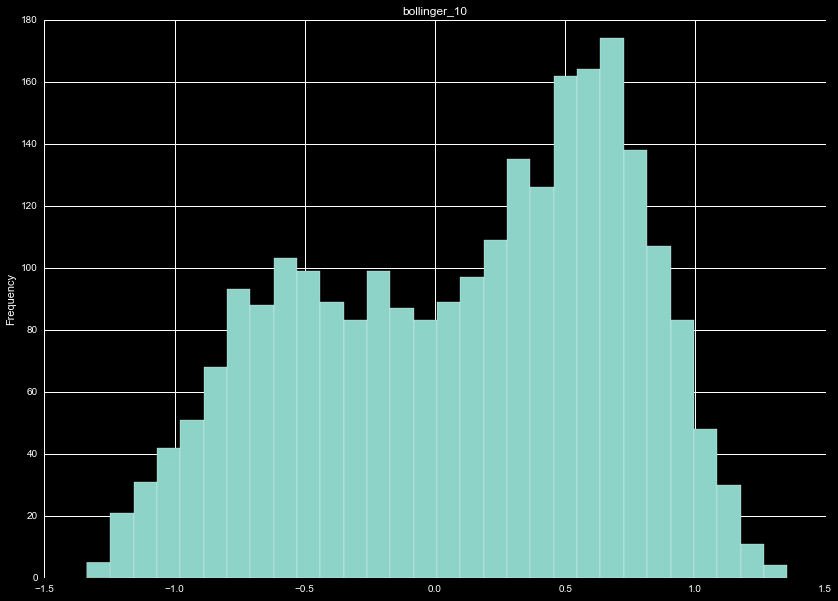

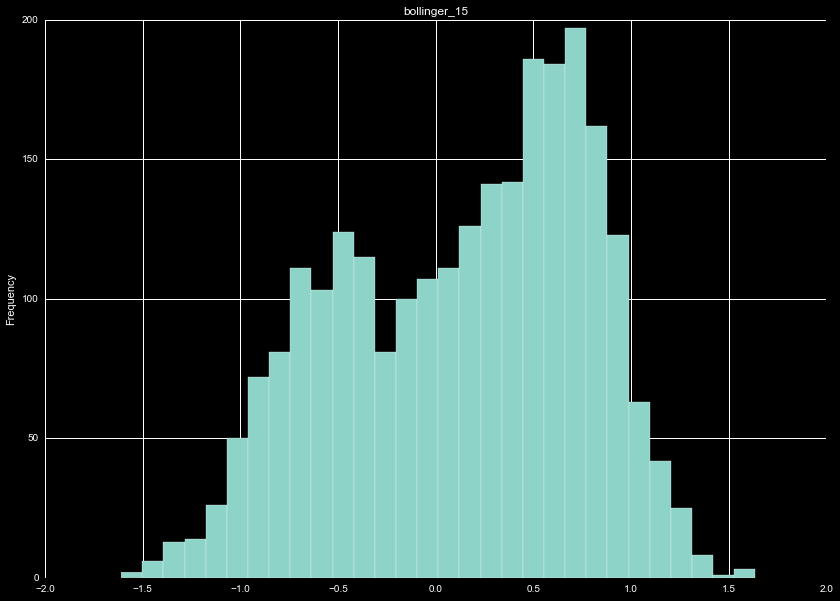

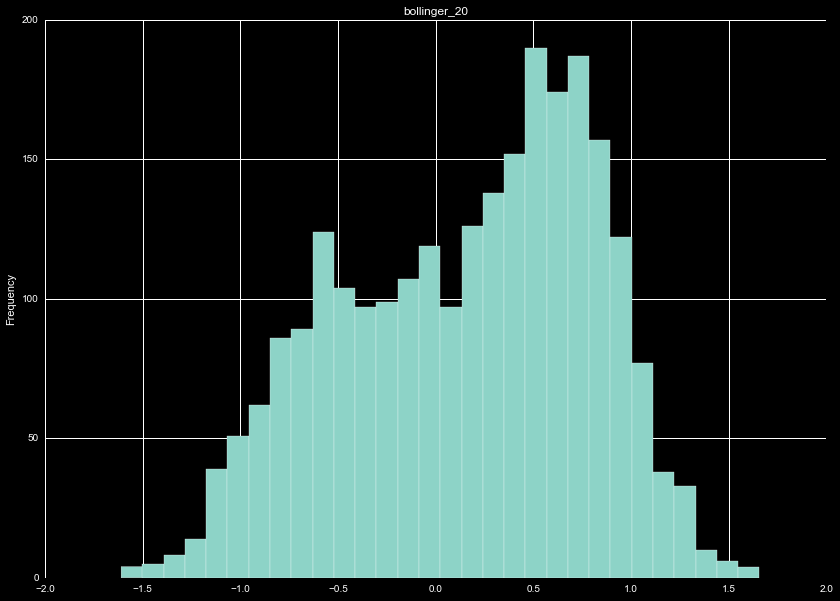

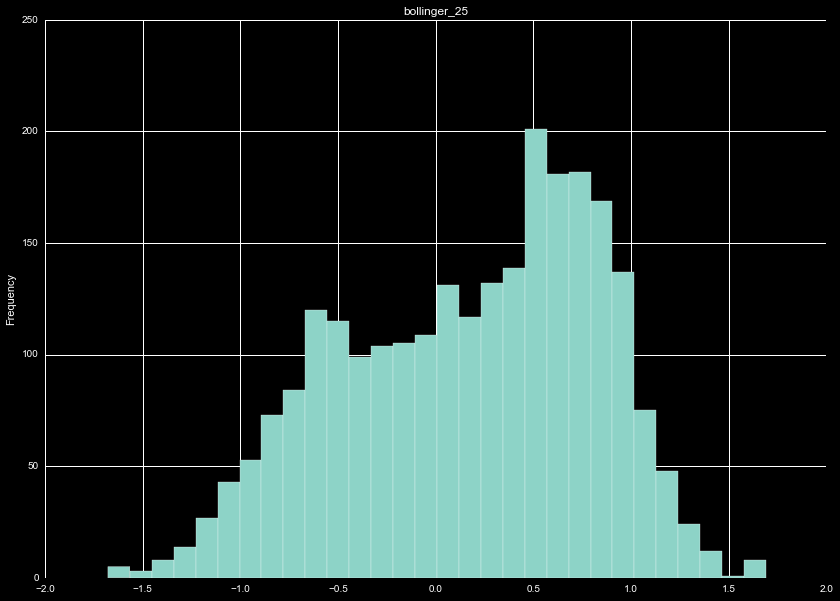

In [29]:
for i in band_nums:
    label = 'bollinger_'+str(i)
    my_df[label].plot.hist( bins=30, title=label )
    plt.show()

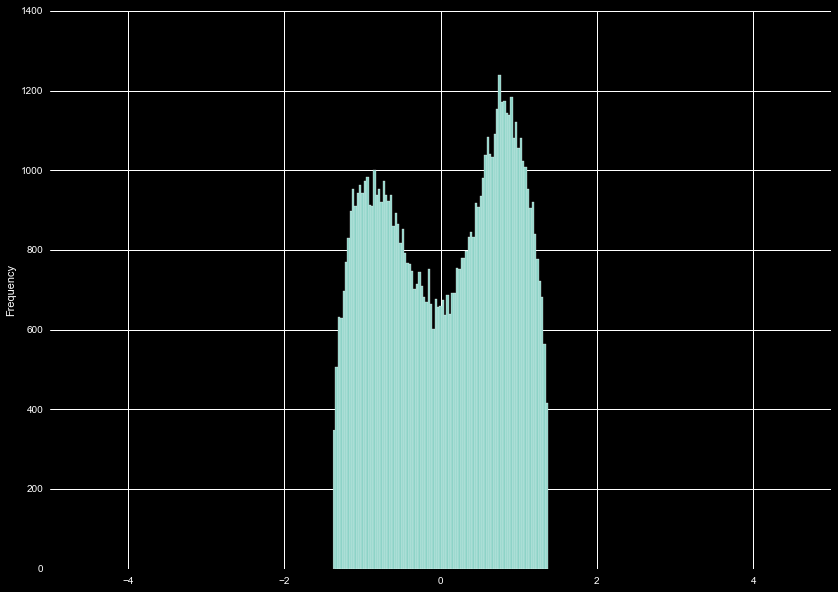

0.0290208314093
0.515398980214
count    77750.000000
mean         0.044647
std          0.792922
min         -1.375864
25%         -0.683292
50%          0.101551
75%          0.761471
max          1.376042
Name: bollinger_5, dtype: float64


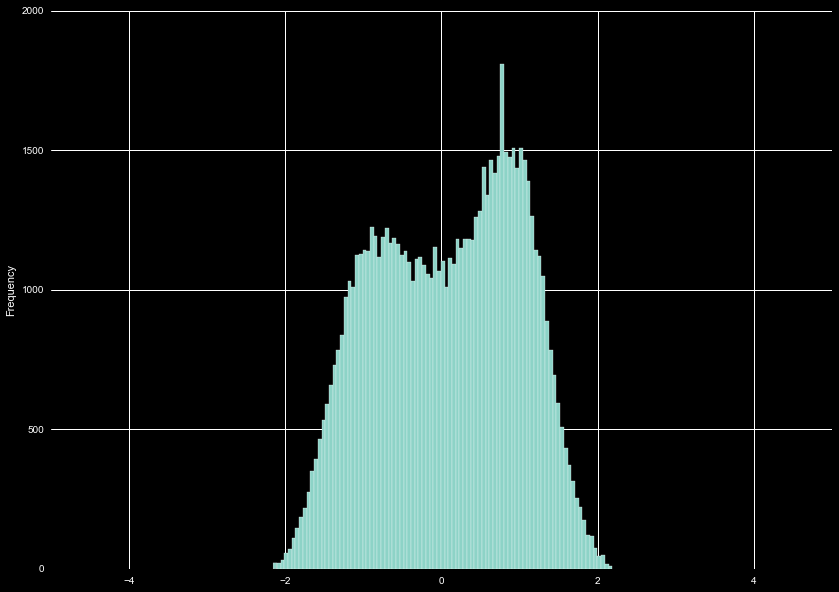

0.0481675720392
0.594631829725
count    77750.000000
mean         0.074104
std          0.914818
min         -2.154351
25%         -0.696384
50%          0.140115
75%          0.838445
max          2.186926
Name: bollinger_10, dtype: float64


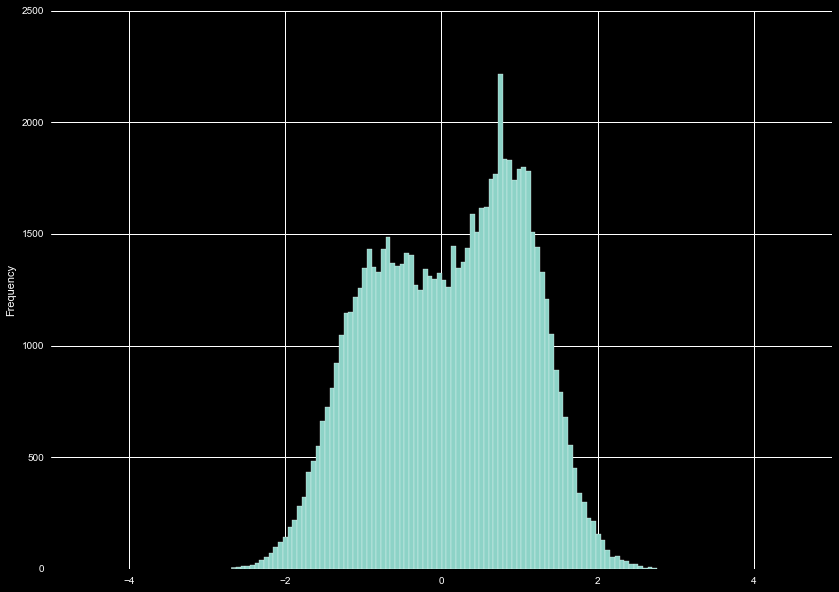

0.0629709810393
0.626351668658
count    77750.000000
mean         0.096878
std          0.963618
min         -2.688443
25%         -0.692623
50%          0.174785
75%          0.878814
max          2.758713
Name: bollinger_15, dtype: float64


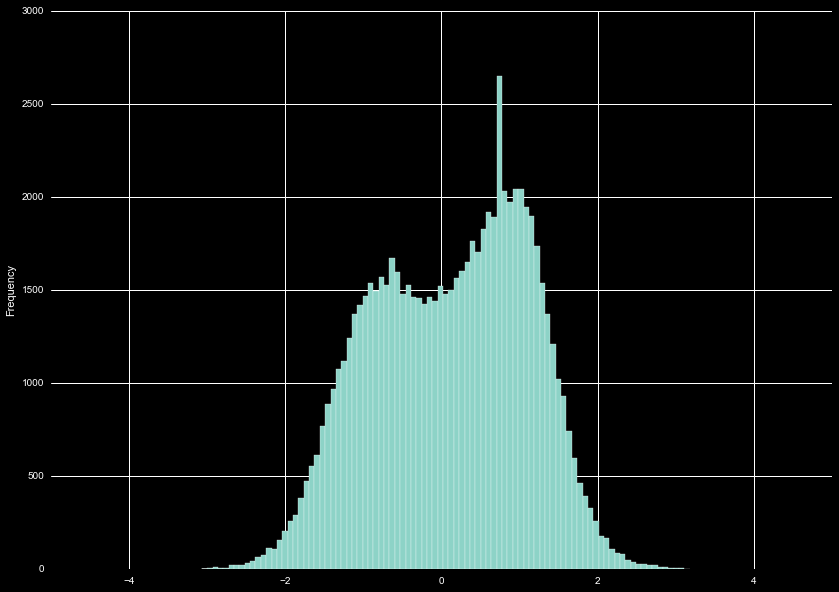

0.0742184008506
0.644108983983
count    77750.000000
mean         0.114182
std          0.990937
min         -3.066769
25%         -0.682152
50%          0.202974
75%          0.909804
max          3.178801
Name: bollinger_20, dtype: float64


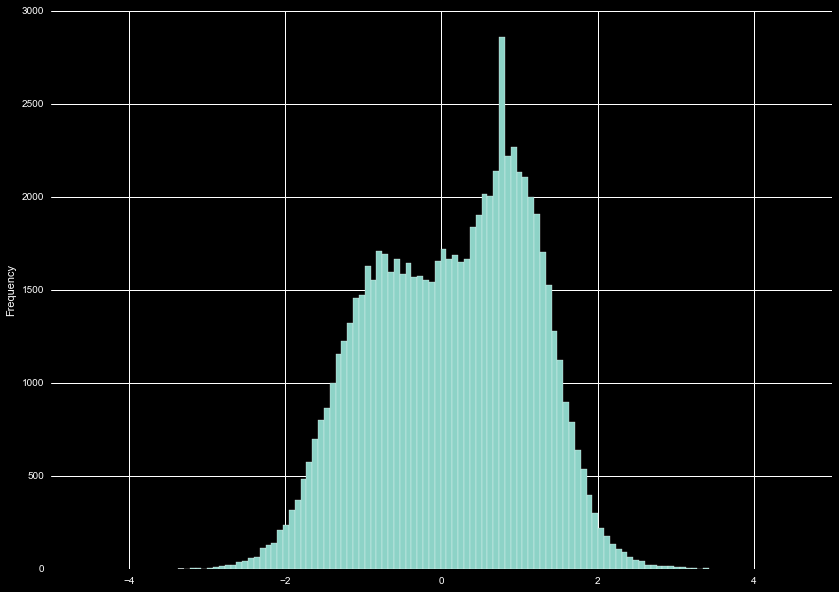

0.0824026192075
0.655306199992
count    77750.000000
mean         0.126773
std          1.008163
min         -3.371778
25%         -0.680382
50%          0.215376
75%          0.924712
max          3.426924
Name: bollinger_25, dtype: float64


In [102]:
for i in band_nums:
    label = 'bollinger_'+str(i)
    #foo, vals = rv.smart_scale( my_df, label, n_sigma=2.0, show_final=True, curve_boost=1e4, return_coeff=True )
    #scale_dict[label+'_mean'] = vals[0]
    #scale_dict[label+'_std' ] = vals[1]
    #foo = rv.scale_column(my_df,label)#smart_scale( my_df, label, n_sigma=10.0, show_final=True, curve_boost=1e4, return_coeff=True, )
    #vals[0] = foo.mean()
    #vals[1] = foo.std()
    #scale_dict[label+'_mean'] = my_df[label].mean()
    #scale_dict[label+'_std' ] = my_df[label].std()
    foo = ( (my_df[label] - 0.0 ) / 0.65 )
    foo.plot.hist( bins=91 )
    plt.xlim(-5,5)
    plt.show()
    print my_df[label].mean()
    print my_df[label].std()
    print foo.describe()

In [121]:
scale_dict['band_mean'] = 0.0
scale_dict['band_std' ] = 0.65

In [31]:
my_df.columns.values

array(['diff_co', 'diff_hl', 'momentum_3', 'momentum_5', 'momentum_10',
       'momentum_15', 'momentum_20', 'momentum_25', 'momentum_30', 'rsi_5',
       'rsi_10', 'rsi_15', 'rsi_20', 'rsi_25', 'bollinger_5',
       'bollinger_10', 'bollinger_15', 'bollinger_20', 'bollinger_25',
       'frac_year_1', 'frac_year_2', 'agri_ind', 'cons_ind', 'ener_ind',
       'tran_ind', 'wate_ind', 'close', 'log_diff_hl'], dtype=object)

In [36]:
print my_df['frac_year_1'].describe()
print my_df['frac_year_2'].describe()

count    2519.000000
mean        0.005085
std         0.571985
min        -0.989071
25%        -0.491803
50%         0.005464
75%         0.500000
max         1.000000
Name: frac_year_1, dtype: float64
count    2519.000000
mean        0.001955
std         0.582298
min        -1.000000
25%        -0.505464
50%        -0.005464
75%         0.508197
max         1.000000
Name: frac_year_2, dtype: float64


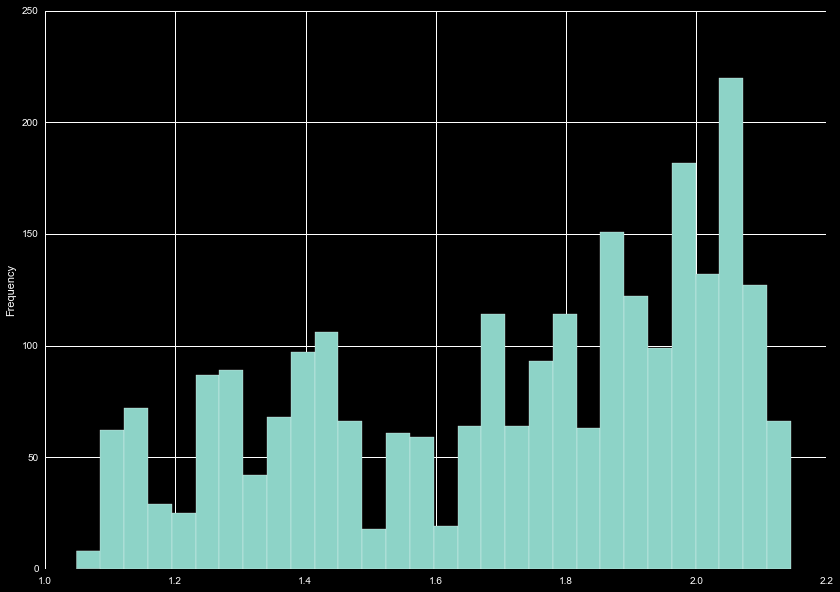

In [37]:
my_df['close'].plot.hist( bins=30 )

In [128]:
print scale_dict

{'momentum_std': 0.1, 'momentum_mean': 0.0, 'log_diff_hl_mean': -1.667078111950647, 'band_std': 0.65, 'diff_co_std': 0.02100457926701524, 'band_mean': 0.0, 'rsi_mean': 0.5, 'diff_co_mean': 0.00022497482720997827, 'rsi_std': 0.2, 'log_diff_hl_std': 0.25359619332368516}


In [123]:
import pickle

In [126]:
with open('quotes/scaling_dict.pkl','wb') as handle:
    pickle.dump( scale_dict, handle, protocol=pickle.HIGHEST_PROTOCOL )